# Notebook that runs model code and exports all necessary data packaged for plotting results in R

In [1]:
# allow import of my own local version of the phydra model (based on github folder structure)
import sys
sys.path.append('../../phydra_OSM/')

import pandas

# then import necessary packages and phydra code
import time
import numpy as np
from lmfit import Parameters
from phydra.model import cariacoNPZD
from phydra.core import ModelSetup

from scipy.integrate import odeint

In [2]:
parameters = Parameters()

# NUTRIENT(s)
parameters.add('nuts_num', value=1)
parameters.add('nuts1_nuttype', value=0)  # Nitrate

# PHYTOPLANKTON(s)
parameters.add('phyto_num', value=1)
parameters.add('OptI', value=40, vary=False)    # Optimum irradiance (einstein*m^-2*d^-1)
#parameters.add('alpha', value=0.15, vary=False)  # initial slope of the P-I curve 0.034
#parameters.add('VpMax', value=2.5, vary=False)    # maximum photosynthetic rate

parameters.add('moP', value=0.1, vary=False)    # Phytoplankton mortality (d^-1)

#parameters.add('ratioSi', value=0, vary=False)  # Silicate ratio ## FALLBACK PARAM FOR OTHER PFTs
parameters.add('U_N', value=1.5, vary=False)    # Nitrate Half Saturation Constant
#parameters.add('U_P', value=0, vary=False)    # Phosphate Half Saturation Constant
parameters.add('U_Si', value=0, vary=False)   # Silicate Half Saturation Constant
parameters.add('muP', value=1.2, vary=False)    # Phytoplankton maximum growth rate (d^-1)
parameters.add('v', value=1, vary=False)    # Phytoplankton sinking rate (m d^-1)

# ZOOPLANKTON(s)
parameters.add('zoo_num', value=1)
parameters.add('moZ', value=0.01, vary=False)        # Zooplankton mortality (d^-1)
parameters.add('deltaZ', value=0.75, vary=False)    # Zooplankton Grazing assimilation coefficient (-)

parameters.add('Kp', value=1.5, vary=False)     # Zooplankton Grazing saturation constant (-)
parameters.add('pred', value=0.1, vary=False)  # quadratic higher order predation rate on zooplankton
parameters.add('muZ', value=1.0, vary=False)    # Zooplankton maximum grazing rate (d^-1)

# ZOO Feed Prefs
parameters.add('zoo1_P1', value=.67, vary=False)
parameters.add('zoo1_D1', value=.33, vary=False)

# CONVERT FEEDPREFS TO GRAZEPREF FOR CALCULATION OF GRAZING
#parameters.add('zoo1_Zint_grazed1', value=parameters['zoo1_Zint_feed1'].value, vary=False)

parameters.add('phyto1_Z1', value=parameters['zoo1_P1'].value, vary=False)
parameters.add('det1_Z1', value=parameters['zoo1_D1'].value, vary=False)

# DETRITUS (non-biotic pools)
parameters.add('det_num', value=1)
parameters.add('deltaD_N', value=0.01, vary=False)   # Nitrate Remineralization rate (d^-1)

# PHYSICS
#parameters.add('kappa', value=0.1, vary=False)  # vary=False) # min=0.09, max=0.11) # Diffusive mixing across thermocline (m*d^-1)
parameters.add('kw', value=0.04, vary=False)     # Light attenuation constant of water (m^-1)
parameters.add('kc', value=0.03, vary=False)      # Light attenuation via phytoplankton pigment (m^-1)

#NEW EMPOWER:
#parameters.add('moP_quad', value=0.025, vary=False)    # Phytoplankton mortality (d^-1)

parameters.add('wmix', value=0.1, vary=False)
parameters.add('beta_feed', value=0.69, vary=False)
parameters.add('kN_feed', value=0.75, vary=False)
parameters.add('vD', value=1., vary=False)

######### MODEL EVALUATION CODE #############

ms = ModelSetup(parameters, physics='Box', forcing='fullTS', time=None, pad=True)

n, p, z, d = ms.classes

physx = ms.physics

N0 = 5
P0 = 0.1
Z0 = 0.1
D0 = 0.1

initnut = [N0 for i in range(n.num)]
initphy = [P0 for i in range(p.num)]
initzoo = [Z0 for i in range(z.num)]
initdet = [D0 for i in range(d.num)]
initout = [0 for i in range(23)]
initcond = np.concatenate([initnut, initphy, initzoo, initdet,initout], axis=None)

timedays = np.arange(0., 7742., 1.0)

# INTEGRATE:
tos = time.time()
print('starting integration')
outarray = odeint(cariacoNPZD, initcond, timedays, args=(ms, None))  # for some reason need to pass 2 args
tos1 = time.time()
print('finished after %4.3f sec' % (tos1 - tos))

#print(outarray)



Nitrate 0 created
phyto 0 created
D feedpref [0.33] P feedpref [0.67]
zoo 0 created
det 0 created
x258depth forcing created
NO3_NO2_USF forcing created
SiO4_USF forcing created
Temperature forcing created
PAR forcing created
Verification data created
starting integration
finished after 4.809 sec


In [3]:
# create aggTS model verification data for later analysis

#ms1 = ModelSetup(parameters, physics='Box', forcing='aggTS', time='regime1')
#ms2 = ModelSetup(parameters, physics='Box', forcing='aggTS', time='regime2')

In [4]:
"""
outarray_reg1, timedays_reg1, df_reg1 = ms.physics.forcing.NOX.returnModelOut_Regime(outarray,timedays, regime=1)
outarray_reg2, timedays_reg2, df_reg2 = ms.physics.forcing.NOX.returnModelOut_Regime(outarray,timedays, regime=2)

timedays_reg1x = np.mod(timedays_reg1-timedays_reg1[0], 365)
timedays_reg2x = np.mod(timedays_reg2-timedays_reg2[0], 365)

#if ms.physics.forcing.NOX.extendstart:
#    print(len(outarray), len(timedays))
#    outarray = ms.physics.forcing.NOX.returnModelOut_nospinup(outarray)
#    timedays = ms.physics.forcing.NOX.returnTimeDays_nospinup(timedays)

nn = ms.nutrients.num
pn = ms.phytoplankton.num
zn = ms.zooplankton.num
dn = ms.detritus.num
nuts = slice(0, nn)
phyto = slice(nn, nn+pn)
zoo = slice(nn + pn, nn + pn + zn)
det = slice(nn + pn + zn, nn + pn + zn + dn)
flux = slice(nn + pn + zn + dn, None)

outindex = nn + pn + zn + dn
print('outindex', outindex)


def returnmodoutdat(MS,OUTARRAY,timed, regime):
    N = OUTARRAY[:, nuts][:, 0]
    Si = OUTARRAY[:, nuts][:, 1]
    Pall = OUTARRAY[:, phyto]
    PFT_all = np.sum(Pall, axis=1)
    PFT_1 = Pall[:, 0]
    PFT_2 = Pall[:, 1]
    Zall = OUTARRAY[:, zoo][:,0]
    Det = OUTARRAY[:, det][:,0]
    
    if regime == '_reg1':
        df_reg = df_reg1
    else:
        df_reg = df_reg2
    
    
    data = {'N':N,
            'Si':Si,
            'PFT_all':PFT_all,
            'PFT_1':PFT_1,
            'PFT_2':PFT_2,
            'Zall':Zall,
            'Det':Det,
           'time':timed,
           'date':df_reg.index}
    return data


# intialise data of lists. 
modout_reg1 = returnmodoutdat(ms1,outarray_reg1, timedays_reg1,'_reg1')
# Create DataFrame 
out_1 = pandas.DataFrame(modout_reg1) 
# Print the output. 
out_1.to_csv('modelout_reg1.csv')


# intialise data of lists. 
modout_reg2 = returnmodoutdat(ms2, outarray_reg2, timedays_reg2,'_reg2')
# Create DataFrame 
out_2 = pandas.DataFrame(modout_reg2) 
# Print the output. 
out_2.to_csv('modelout_reg2.csv')


NOX = ms.physics.forcing.NOX.return_interpvalattime(timedays_reg1)

NOXdat = ms.physics.forcing.NOX.forcingfile

NN = ms.physics.forcing.NOX.rawforcing

SiOX = ms.physics.forcing.SiOH.return_interpvalattime(timedays_reg1)

SiOXdat = ms.physics.forcing.SiOH.forcingfile

SiX = ms.physics.forcing.SiOH.rawforcing

MLDRAW = ms.physics.forcing.X258.rawforcing

MLD = ms.physics.forcing.X258.return_interpvalattime(timedays_reg1)
# MLDderiv = ms.physics.forcing.X258.return_derivattime(timedays_ly)
MLDdat = ms.physics.forcing.X258.forcingfile
MLD_max = 150  # np.max(MLDdat) + 0.1 * np.max(MLDdat)

PARAW = ms.physics.forcing.PAR.rawforcing

PAR = ms.physics.forcing.PAR.return_interpvalattime(timedays_reg1)
PARdat = ms.physics.forcing.PAR.forcingfile

TmldRAW = ms.physics.forcing.SST.rawforcing

Tmld = ms.physics.forcing.SST.return_interpvalattime(timedays_reg1)
Tmlddat = ms.physics.forcing.SST.forcingfile



def returnregdat(timed,timex, regime):
    NOX = ms.physics.forcing.NOX.return_interpvalattime(timed)
    SiOX = ms.physics.forcing.SiOH.return_interpvalattime(timed)
    MLD = ms.physics.forcing.X258.return_interpvalattime(timed)
    PAR = ms.physics.forcing.PAR.return_interpvalattime(timed)
    Tmld = ms.physics.forcing.SST.return_interpvalattime(timed)
    
    if regime == '_reg1':
        df_reg = df_reg1
    else:
        df_reg = df_reg2
    
    
    
    data = {'NOX':NOX,
           'SiOX':SiOX,
           'x258':MLD,
           'PAR':PAR,
           'Tmld':Tmld,
           'time':timed,
           'yday':timex+1,
           'date':df_reg.index}
    return data


# intialise data of lists. 
forcing_reg1 = returnregdat(timedays_reg1, timedays_reg1x, '_reg1')
# Create DataFrame 
df_1 = pandas.DataFrame(forcing_reg1) 
# Print the output. 
df_1.to_csv('forcing_reg1.csv')


# intialise data of lists. 
forcing_reg2 = returnregdat(timedays_reg2, timedays_reg2x, '_reg2')
# Create DataFrame 
df_2 = pandas.DataFrame(forcing_reg2) 
# Print the output. 
df_2.to_csv('forcing_reg2.csv')
"""

# get full output:

df_full_X = ms.physics.forcing.NOX.returnFullDF_nospinup()
outarray_X = ms.physics.forcing.NOX.returnModelOut_nospinup(outarray, full=True)
timedays_X = ms.physics.forcing.NOX.returnTimeDays_nospinup(timedays, full=True)




########
TOToutarray = pandas.DataFrame(outarray_X, columns=['N','P','Z','D',
                                      'PTempDepGrow','PNutUptake','PLightHarv','PGains',
                                      'Mix','','PMortality','PZooGrazed','PSinking','PLosses',
                                      'ZGains','ZLinMort','ZQuadMort','SiMixing','ZLosses',
                                      'ZUnassimFeedDetritus','DGains','DRemin','DZooGrazed',
                                      'DSinking', 'DLosses','NMixing','ZUnassimFeedNitrate'])

TOToutarray = TOToutarray[:7737]
TOToutarray.insert(0, "time", timedays_X[:7737]) 

print(str(df_full_X.index), len(df_full_X.index))

print(str(timedays_X), len(timedays_X))

TOToutarray.insert(0, "date", df_full_X.index) 

TOToutarray.to_csv('outarray_full_NPZD.csv')

No need to remove spinup phase
No need to remove spinup phase
DatetimeIndex(['1995-11-08', '1995-11-09', '1995-11-10', '1995-11-11',
               '1995-11-12', '1995-11-13', '1995-11-14', '1995-11-15',
               '1995-11-16', '1995-11-17',
               ...
               '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12'],
              dtype='datetime64[ns]', name='date', length=7737, freq='D') 7737
[0.000e+00 1.000e+00 2.000e+00 ... 7.739e+03 7.740e+03 7.741e+03] 7742


In [5]:
%load_ext rpy2.ipython

/Users/bpo/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [9]:
%%R

require(ggplot2, warn.conflicts = FALSE);
require(tidyverse, warn.conflicts = FALSE);
require(cowplot, warn.conflicts = FALSE);
library(scales)

outarray_full <- read.csv("outarray_full_NPZD.csv")
outarray_full$date <- as.Date(outarray_full$date)

modelout_reg1 <- read.csv("modelout_reg1.csv")
modelout_reg2 <- read.csv("modelout_reg2.csv")
modelout_reg1$date <- as.Date(modelout_reg1$date)
modelout_reg2$date <- as.Date(modelout_reg2$date)

outarray_full_reg1 = outarray_full[outarray_full$date > as.Date(head(modelout_reg1$date, n=1)) & outarray_full$date < as.Date(tail(modelout_reg1$date, n=1)),]
outarray_full_reg2 = outarray_full[outarray_full$date > as.Date(head(modelout_reg2$date, n=1)) & outarray_full$date < as.Date(tail(modelout_reg2$date, n=1)),]

forcing_reg1 <- read.csv("forcing_reg1.csv")
forcing_reg2 <- read.csv("forcing_reg2.csv")
forcing_reg1$date <- as.Date(forcing_reg1$date)
forcing_reg2$date <- as.Date(forcing_reg2$date)

# READ VERIFICATION

BoxVSatDepth <- read.csv("../Data/NewestData/BoxVSatDepth_02.csv")
CHLA_df <- read.csv("../Data/NewestData/HPLCPinckneyTotAndSpec_03.csv")
ZOO_df <- read.csv("../Data/NewestData/ZooplanktonData_05.csv")

BoxVSatDepth$date <- as.Date(BoxVSatDepth$date)
BoxVSatDepth$month <- as.integer(BoxVSatDepth$month)
CHLA_df$date <- as.Date(CHLA_df$date)
ZOO_df$date <- as.Date(ZOO_df$date)

BoxVSatDepth_reg1 = BoxVSatDepth[BoxVSatDepth$date > head(modelout_reg1$date, n=1) & BoxVSatDepth$date < tail(modelout_reg1$date, n=1),]
BoxVSatDepth_reg2 = BoxVSatDepth[BoxVSatDepth$date > head(modelout_reg2$date, n=1) & BoxVSatDepth$date < tail(modelout_reg2$date, n=1),]

CHLA_df_reg1 = CHLA_df[CHLA_df$date > head(modelout_reg1$date, n=1) & CHLA_df$date < tail(modelout_reg1$date, n=1),]
CHLA_df_reg2 = CHLA_df[CHLA_df$date > head(modelout_reg2$date, n=1) & CHLA_df$date < tail(modelout_reg2$date, n=1),]

ZOO_df_reg1 = ZOO_df[ZOO_df$date > head(modelout_reg1$date, n=1) & ZOO_df$date < tail(modelout_reg1$date, n=1),]
ZOO_df_reg2 = ZOO_df[ZOO_df$date > head(modelout_reg2$date, n=1) & ZOO_df$date < tail(modelout_reg2$date, n=1),]


###########################

CtoChla = 50  # g/g
MolarMassC = 12.0107
CtoNratioPhyto = 6.625
Chlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to


mggramstograms = 1 / 1000
Cperdryweight = 0.32
# Wiebe et al. 1975 : Carbon was 31-33% ofdryweight
molarmassCarbon = 12.01  # grams per mole
CtonNratioZoo = 5.625
mgDWtomuMolarZOO = mggramstograms / Cperdryweight / molarmassCarbon / CtonNratioZoo * 1000  # µM

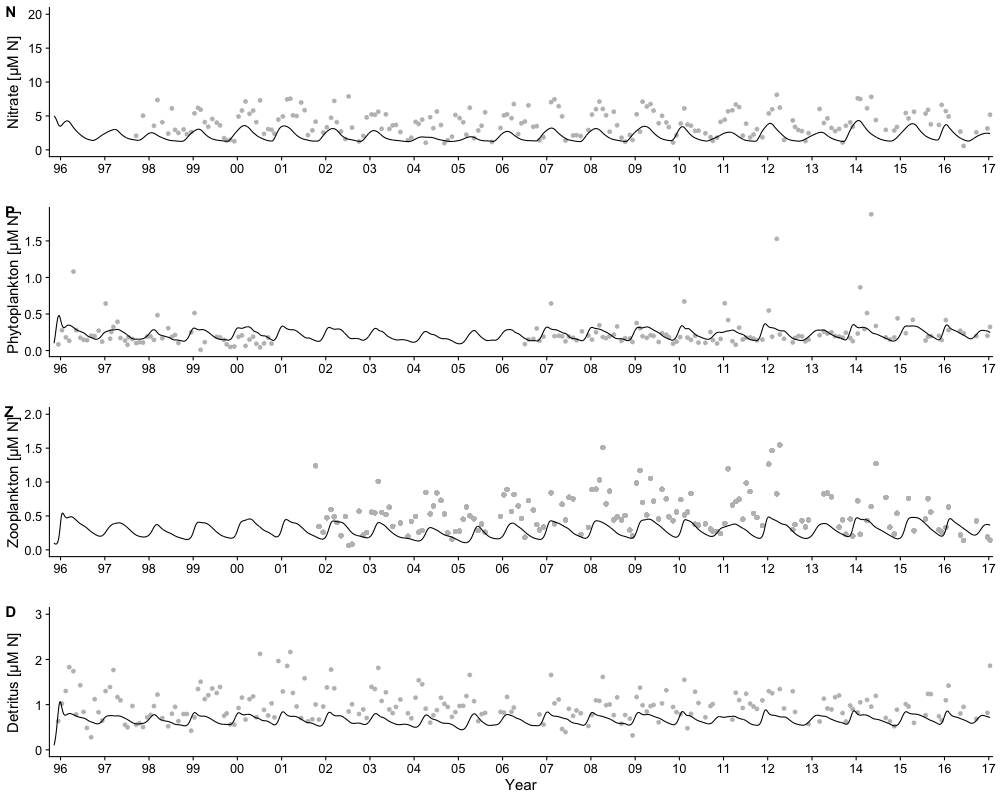

In [8]:
%%R -w 1000 -h 800

linealpha = 0.5
ts1linecol = 'red'
ts2linecol = 'blue'

datelim1 = as.Date('1995-10-01')
datelim2 = as.Date('2017-02-01')

p1 <- ggplot() +
    # env data
    geom_point(data=BoxVSatDepth, aes(date, NO3_NO2_USF_Box), col='grey') +
    #geom_point(data=BoxVSatDepth[BoxVSatDepth$date < as.Date('1997-09-01'),], aes(date, NO3_UDO_Box)) +
    # model out
    geom_line(data=outarray_full,aes(x=date, y=N)) +
    #geom_point(data=BoxVSatDepth_reg1, aes(date, NO3_UDO_Box)) +
    theme_cowplot(15) + ylim(0,20)+
    ylab('Nitrate [µM N]') + xlab('') +
        
    scale_x_date(date_breaks = "years", labels = date_format('%y'), limits=c(datelim1,datelim2), expand=expand_range(0))#+
    
    # Time 1
    #geom_vline(xintercept=as.Date('1996-01-01'), alpha = linealpha, col=ts1linecol)+
    #geom_vline(xintercept=as.Date('2000-10-30'), alpha = linealpha, col=ts1linecol)+
    
    # Time 2
    #geom_vline(xintercept=as.Date('2006-06-30'), alpha = linealpha, col=ts2linecol)+
    #geom_vline(xintercept=as.Date('2010-12-31'), alpha = linealpha, col=ts2linecol)
    
    
p3 <- ggplot() + 
    # env data
    #geom_point(data=BoxVSatDepth, aes(date, Chlorophyll_Box * Chlaconvfactor)) +
    geom_point(data=CHLA_df, aes(date, Tchla/100 * Chlaconvfactor), col='grey') +
    # model out
    #geom_line(data=outarray_full,aes(x=date, y=P), col='red') +
    geom_line(data=outarray_full,aes(x=date, y=P)) +
    #geom_line(data=outarray_full,aes(x=date, y=P1+P2), col='black', size=2) +
    #geom_point(data=BoxVSatDepth_reg1, aes(date, NO3_UDO_Box)) +
    theme_cowplot(15) + #ylim(0,6)+
    ylab('Phytoplankton [µM N]') + xlab('') + #scale_y_log10(limits=c(0.01,4))+
    
    scale_x_date(date_breaks = "years", labels = date_format('%y'), limits=c(datelim1,datelim2), expand=expand_range(0))#+
    
    # Time 1
    #geom_vline(xintercept=as.Date('1996-01-01'), alpha = linealpha, col=ts1linecol)+
    #geom_vline(xintercept=as.Date('2000-10-30'), alpha = linealpha, col=ts1linecol)+
    
    # Time 2
    #geom_vline(xintercept=as.Date('2006-06-30'), alpha = linealpha, col=ts2linecol)+
    #geom_vline(xintercept=as.Date('2010-12-31'), alpha = linealpha, col=ts2linecol)
    
    
    
p4 <- ggplot() + 
    # env data
    geom_point(data=ZOO_df, aes(date, BIOMASS_200 * mgDWtomuMolarZOO), col='grey') +
    #geom_point(data=ZOO_df, aes(date, BIOMASS_500 * mgDWtomuMolarZOO), col='blue') +
    # model out
    geom_line(data=outarray_full,aes(x=date, y=Z)) +
    
    theme_cowplot(15) + ylim(0,2.)+
    ylab('Zooplankton [µM N]') + xlab('') +
    
    scale_x_date(date_breaks = "years", labels = date_format('%y'), limits=c(datelim1,datelim2), expand=expand_range(0))#+
    
    # Time 1
    #geom_vline(xintercept=as.Date('1996-01-01'), alpha = linealpha, col=ts1linecol)+
    #geom_vline(xintercept=as.Date('2000-10-30'), alpha = linealpha, col=ts1linecol)+
    
    # Time 2
    #geom_vline(xintercept=as.Date('2006-06-30'), alpha = linealpha, col=ts2linecol)+
    #geom_vline(xintercept=as.Date('2010-12-31'), alpha = linealpha, col=ts2linecol)
    
    
    
p5 <- ggplot() + 
    # env data
    geom_point(data=BoxVSatDepth, aes(date, PON_ug_kg_Box/ 14.0067),col='grey') +
    # model out
    geom_line(data=outarray_full,aes(x=date, y=D)) +

    theme_cowplot(15) + ylim(0,3.)+
    ylab('Detritus [µM N]') + xlab('Year') +
    
    scale_x_date(date_breaks = "years", labels = date_format('%y'), limits=c(datelim1,datelim2), expand=expand_range(0))#+
    
    # Time 1
    #geom_vline(xintercept=as.Date('1996-01-01'), alpha = linealpha, col=ts1linecol)+
    #geom_vline(xintercept=as.Date('2000-10-30'), alpha = linealpha, col=ts1linecol)+
    
    # Time 2
    #geom_vline(xintercept=as.Date('2006-06-30'), alpha = linealpha, col=ts2linecol)+
    #geom_vline(xintercept=as.Date('2010-12-31'), alpha = linealpha, col=ts2linecol)
    
    
    
NPZDplotX <- plot_grid(p1,p3,p4,p5, labels = c('N','P','Z','D'), 
          label_size=15, ncol=1, align = 'v')
#hjust = -12.8

NPZDplotX

In [32]:
%%R

saveplot <- function(filename, plotobj, width=11, height=6, useDingbats=FALSE){
    ggsave(paste(filename,'.pdf', sep=''), plotobj, width=width, height=height, useDingbats=useDingbats)
}

saveplot('NPZDplotX',NPZDplotX, width=10, height=8)

In [31]:
%%R

library(padr)

test1 = data.frame(date = CHLA_df$date, Tchla = CHLA_df$Tchla)

NAmonths <- test1 %>% 
    pad %>% 
    add_column('month'=as.integer(format(.$date, format='%m'))) %>%
    add_column('year'=format(.$date, format='%Y')) %>%
    group_by(year,month)%>%
    summarise(non_na_count = sum(!is.na(Tchla))) %>%
    filter(non_na_count == 0) %>%
    add_column('date'=as.Date(paste(.$year,'-',.$month,'-15',sep='')))

CHLA_df_pad <- bind_rows(CHLA_df, NAmonths)